In [1]:
import cache
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from statistics import mean

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, precision_recall_curve, precision_score, recall_score, f1_score

In [2]:
cache_dir = 'random_forest'

FOLD_COUNT = 10
CONST_N = 5

In [3]:
dataset_names = [
    'abt-buy', 'amazon-google', 'products_(Walmart-Amazon)',
    'wdc_xlarge_computers', 'wdc_xlarge_shoes', 'wdc_xlarge_watches'
]

In [4]:
def create_folds(source, N):
    positives = source.filter(
        pl.col('label')
    ).sample(fraction=1, shuffle=True, seed=0).with_row_count('fold').with_columns(
        pl.col('fold') % FOLD_COUNT
    )
    negatives = source.filter(
        ~pl.col('label')
    ).sample(fraction=1, shuffle=True, seed=0).head(
        positives.shape[0] * N
    ).with_row_count('fold').with_columns(
        pl.col('fold') % FOLD_COUNT
    )
    return pl.concat([positives, negatives])

data = defaultdict(defaultdict)
for key in dataset_names:
    path = f'data/{key}/feature_vector.csv'
    source = pl.scan_csv(
        path
    ).with_columns(
        pl.col('label').cast(pl.Boolean)
    ).collect()
    positives = source.lazy().filter(pl.col('label')).select(pl.count()).collect().item()
    negatives = source.shape[0] - positives
    N = min(negatives // positives, CONST_N)
    data[key]['data'] = create_folds(source, N)
    data[key]['N'] = N

the validation fold is always 1 before the testing fold

In [5]:
# d is the dataset from above
# N is the train ratio (i.e., 1 means 1:1 and 5 means 1:5)
def generate_y_prob(d, N):
    all_y_prob = []
    for i in range(FOLD_COUNT):
        test_fold_index = i
        validation_fold_index = (i - 1) % FOLD_COUNT
        
        # train the model
        X_train = d['data'].head(
            d['data'].shape[0] // (d['N'] + 1) * (N + 1) # sample a number of rows to get the right ratio
        ).filter(
            ~pl.col('fold').is_in([validation_fold_index, test_fold_index]) # remove validation and test fold data
        ).drop('source_id', 'target_id', 'pair_id', 'label', 'fold').to_numpy()
        
        y_train = d['data'].head(
            d['data'].shape[0] // (d['N'] + 1) * (N + 1)
        ).filter(
            ~pl.col('fold').is_in([validation_fold_index, test_fold_index])
        )['label'].to_list()
        
        model = RandomForestClassifier(random_state=0, n_jobs=-1).fit(X_train, y_train)
        
        # validation results
        X_val = d['data'].filter(
            pl.col('fold') == validation_fold_index
        ).drop(
            'source_id', 'target_id', 'pair_id', 'label', 'fold'
        ).to_numpy()
        
        y_val = d['data'].filter(
            pl.col('fold') == validation_fold_index
        )['label'].to_list()
        
        y_prob = pl.DataFrame().with_columns(
            pl.Series('y_prob', model.predict_proba(X_val)[:,1]),
            pl.Series('label', y_val),
            pl.lit(i).alias('fold')
        ).with_row_count('N').with_columns(
            pl.col('N') % d['N'],
            pl.lit('val').alias('set')
        ).select(['y_prob', 'label', 'fold', 'N', 'set'])
        
        all_y_prob.append(y_prob)
        
        # test results
        X_test = d['data'].filter(
            pl.col('fold') == test_fold_index
        ).drop(
            'source_id', 'target_id', 'pair_id', 'label', 'fold'
        ).to_numpy()
        
        y_test = d['data'].filter(
            pl.col('fold') == test_fold_index
        )['label'].to_list()
        
        y_prob = pl.DataFrame().with_columns(
            pl.Series('y_prob', model.predict_proba(X_test)[:,1]),
            pl.Series('label', y_test),
            pl.lit(i).alias('fold')
        ).with_row_count('N').with_columns(
            pl.col('N') % d['N'],
            pl.lit('test').alias('set')
        ).select(['y_prob', 'label', 'fold', 'N', 'set'])
        
        all_y_prob.append(y_prob)
    return pl.concat(all_y_prob)

for key in sorted(data.keys()):
    for N in range(1, data[key]['N'] + 1):
        print(N, key, end=' ' * 20 + '\r')
        y_prob = cache.load(f'{cache_dir}/{key}_{N}', lambda: generate_y_prob(data[key], N))

In [6]:
def get_results(key):
    results = {
        'f1': [],
        'precision': [],
        'recall': [],
        'threshold': [],
        'f1_0.5': [],
        'precision_0.5': [],
        'threshold_0.5': [],
        'recall_0.5': []
    }
    for train in range(1, data[key]['N'] + 1):
        all_y_prob = cache.load(f'{cache_dir}/{key}_{train}')
        for k in results:
            results[k].append([])
        for test in range(1, data[key]['N'] + 1):
            for k in results:
                results[k][-1].append([])
            for fold in range(10):
                # find best threshold
                subset = all_y_prob.filter(pl.col('label') | (pl.col('N') < train))
                y_val = subset.filter(pl.col('set') == 'val')['label'].to_list()
                y_prob = subset.filter(pl.col('set') == 'val')['y_prob'].to_numpy()
                precision, recall, threshold = precision_recall_curve(y_val, y_prob)
                with np.errstate(divide='ignore', invalid='ignore'):
                    f1_scores = np.nan_to_num(2 * recall * precision / (recall + precision))
                threshold = threshold[np.argmax(f1_scores)]
                results['threshold'][-1][-1].append(threshold)

                # get test set results
                subset = all_y_prob.filter(pl.col('label') | (pl.col('N') < test))
                y_test = subset.filter(pl.col('set') == 'test')['label'].to_list()
                y_prob = subset.filter(pl.col('set') == 'test')['y_prob'].to_numpy()
                y_pred = y_prob > threshold
                results['precision'][-1][-1].append(precision_score(y_test, y_pred))
                results['recall'][-1][-1].append(recall_score(y_test, y_pred))
                results['f1'][-1][-1].append(f1_score(y_test, y_pred))

                y_pred = y_prob > 0.5
                results['precision_0.5'][-1][-1].append(precision_score(y_test, y_pred))
                results['recall_0.5'][-1][-1].append(recall_score(y_test, y_pred))
                results['threshold_0.5'][-1][-1].append(0.5)
                results['f1_0.5'][-1][-1].append(f1_score(y_test, y_pred))

            for k in results:
                results[k][-1][-1] = mean(results[k][-1][-1])
    return results

for key in sorted(data.keys()):
    results = cache.load(f'{cache_dir}/{key}_results', lambda: get_results(key))

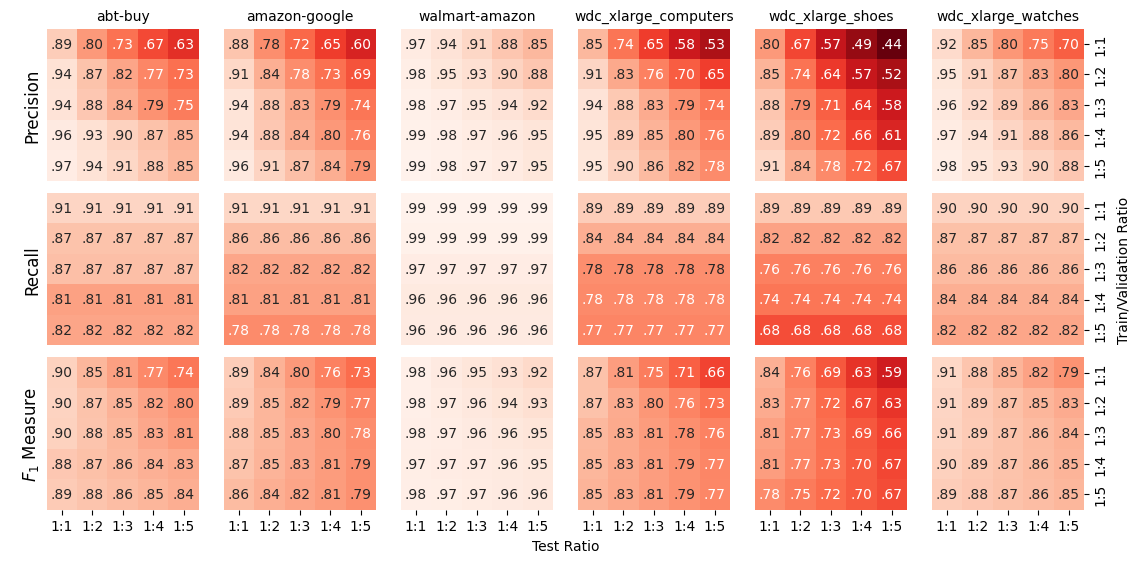

In [7]:
def title(key):
    if key == 'products_(Walmart-Amazon)':
        return 'walmart-amazon'
    return key

def plot(ax, k):
    sns.heatmap(
        np.pad(np.array(results[k]), (0, CONST_N - data[key]['N'])),
        mask=~np.pad(np.full((data[key]['N'], data[key]['N']), True), (0, CONST_N - data[key]['N'])),
        annot=np.vectorize(lambda a: f'{a:.2}'[1:].ljust(3, '0').replace('.00', '1.0'))(np.pad(np.array(results[k]), (0, CONST_N - data[key]['N']))),
        cmap='Reds_r',
        cbar=False,
        fmt='s',
        ax=ax,
        vmin=0.44,
        vmax=1,
        xticklabels=[f'1:{i}' for i in range(1, 6)],
        square=True
    )
    ax.yaxis.tick_right()
    ax.set_yticklabels([f'1:{i}' for i in range(1, 6)], va='center')
    ax.tick_params(bottom=False, right=False, labelbottom=False, labelright=False)

fig, axes = plt.subplots(3, 6, figsize=(12,6))
for i, key in enumerate(dataset_names):
    results = cache.load(f'{cache_dir}/{key}_results', lambda: get_results(key))
    plot(axes[0][i], 'precision')
    axes[0][i].set_title(title(key), fontsize=10)
    plot(axes[1][i], 'recall')
    plot(axes[2][i], 'f1')

for i, label in enumerate(['Precision', 'Recall', '$F_1$ Measure']):
    axes[i][0].set_ylabel(label, fontsize=12)

for r in range(3):
    axes[r][5].tick_params(right=True, labelright=True)
for c in range(6):
    axes[2][c].tick_params(bottom=True, labelbottom=True)

# add a big axis, hide frame
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Test Ratio')
ax.yaxis.set_label_position("right")
ax.set_ylabel('Train/Validation Ratio', labelpad=20)
plt.tight_layout()
plt.show()

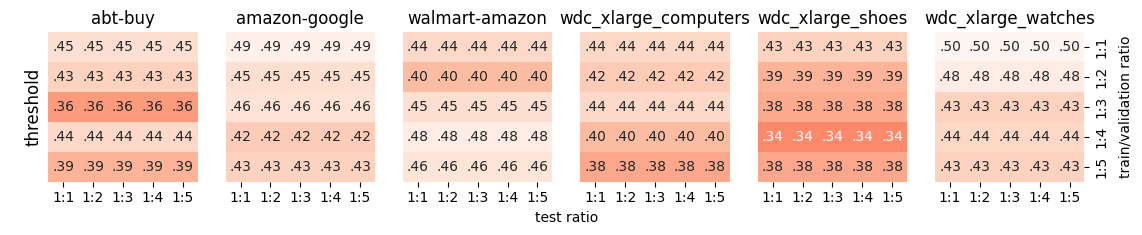

In [8]:
def plot(ax, k):
    sns.heatmap(
        np.pad(np.array(results[k]), (0, CONST_N - data[key]['N'])),
        mask=~np.pad(np.full((data[key]['N'], data[key]['N']), True), (0, CONST_N - data[key]['N'])),
        annot=np.vectorize(lambda a: f'{a:.2}'[1:].ljust(3, '0').replace('.00', '1.0'))(np.pad(np.array(results[k]), (0, CONST_N - data[key]['N']))),
        cmap='Reds_r',
        cbar=False,
        fmt='s',
        ax=ax,
        vmin=0.1,
        vmax=0.5,
        xticklabels=[f'1:{i}' for i in range(1, 6)],
        square=True
    )
    ax.yaxis.tick_right()
    ax.set_yticklabels([f'1:{i}' for i in range(1, 6)], va='center')
    ax.tick_params(right=False, labelright=False)

fig, axes = plt.subplots(1, 6, figsize=(12,2.3))
for i, key in enumerate(dataset_names):
    results = cache.load(f'{cache_dir}/{key}_results', lambda: get_results(key))
    plot(axes[i], 'threshold')
    axes[i].set_title(title(key), fontsize=12)

axes[0].set_ylabel('threshold', fontsize=12)

axes[5].tick_params(right=True, labelright=True)

# add a big axis, hide frame
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('test ratio')
ax.yaxis.set_label_position("right")
ax.set_ylabel('train/validation ratio', labelpad=20)
plt.tight_layout()
plt.show()

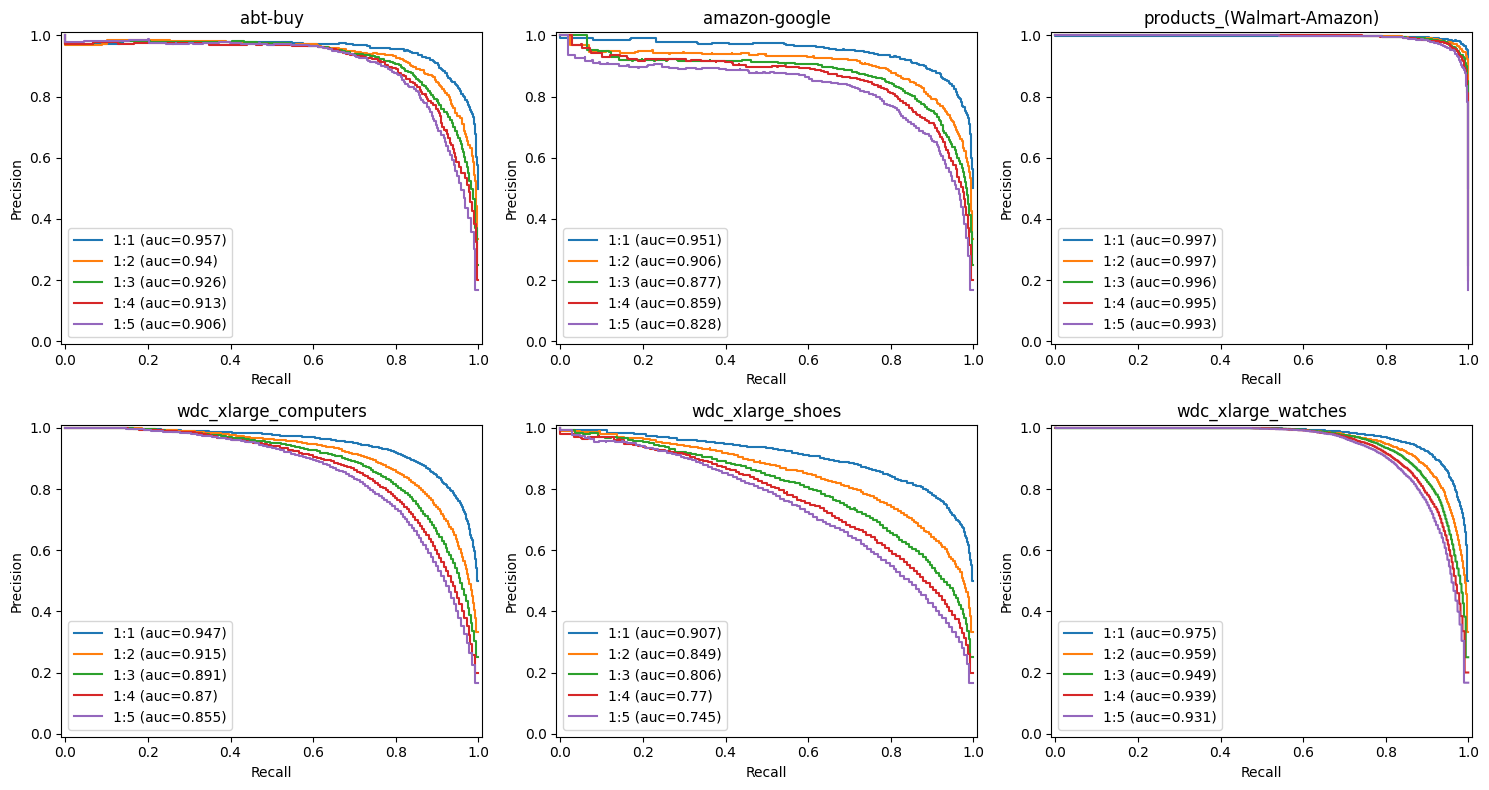

In [9]:
def plot(ax, key, train_N, test_N):
    all_y_prob = cache.load(f'{cache_dir}/{key}_{train_N}')
    subset = all_y_prob.filter(pl.col('label') | (pl.col('N') < test_N))
    y_val = subset.filter(pl.col('set') == 'test')['label'].to_list()
    y_prob = subset.filter(pl.col('set') == 'test')['y_prob'].to_numpy()
    precision, recall, _ = precision_recall_curve(y_val, y_prob)
    ax.step(recall, precision, where='post', label=f'1:{train_N} (auc={auc(recall, precision):.3})')
    
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for j, key in enumerate(dataset_names):
    ax = axes[j // 3][j % 3]
    for i in range(1, 6):
        plot(ax, key, i, i)
    ax.legend(loc='lower left')
    ax.set_title(key)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim((-0.01, 1.01))
    ax.set_ylim((-0.01, 1.01))
plt.tight_layout()
plt.show()

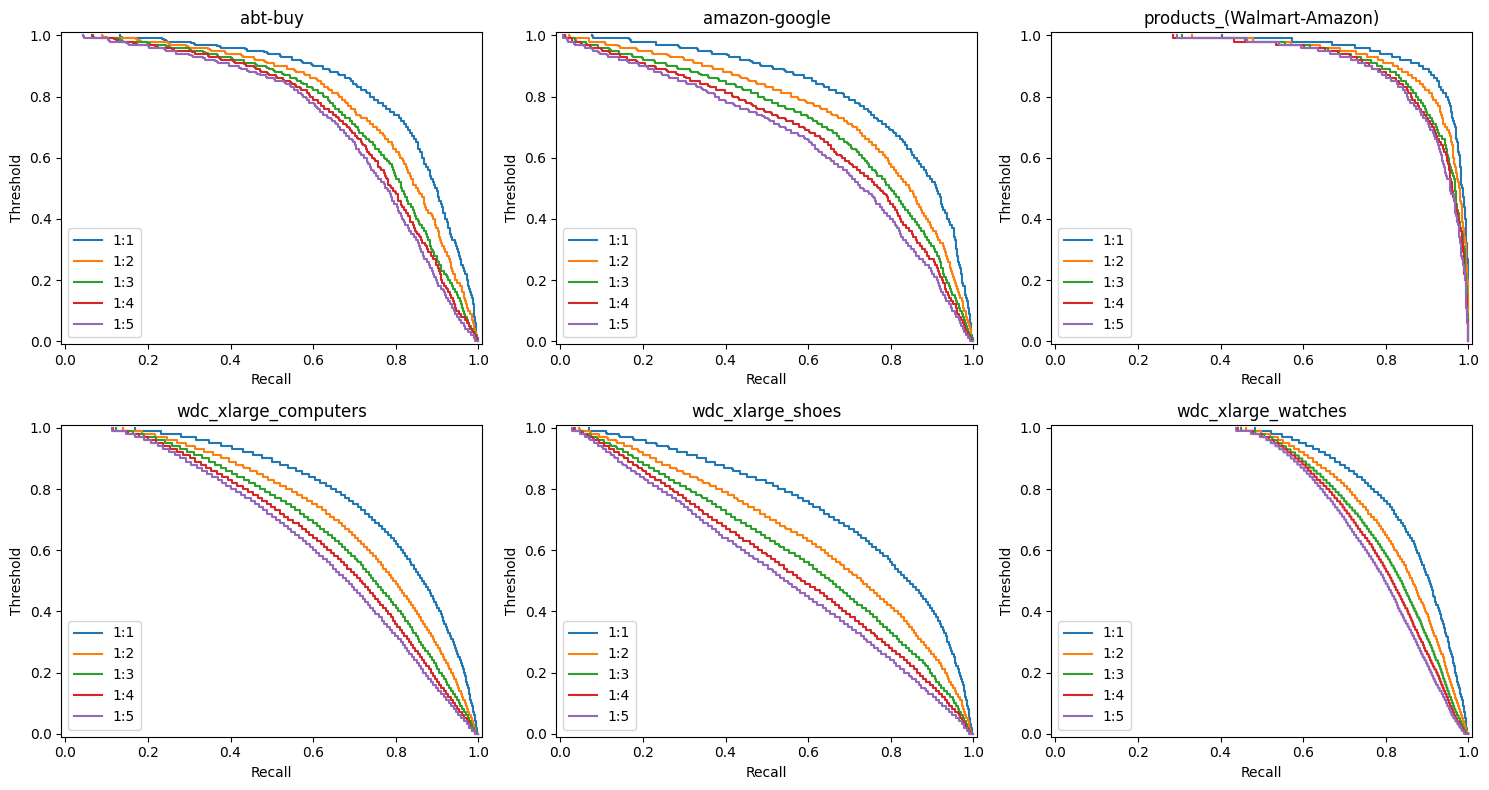

In [10]:
def plot(ax, key, train_N, test_N):
    all_y_prob = cache.load(f'{cache_dir}/{key}_{train_N}')
    subset = all_y_prob.filter(pl.col('label') | (pl.col('N') < test_N))
    y_val = subset.filter(pl.col('set') == 'test')['label'].to_list()
    y_prob = subset.filter(pl.col('set') == 'test')['y_prob'].to_numpy()
    precision, recall, threshold = precision_recall_curve(y_val, y_prob)
    ax.step(recall[:-1], threshold, where='post', label=f'1:{train_N}')
    
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for j, key in enumerate(dataset_names):
    ax = axes[j // 3][j % 3]
    for i in range(1, 6):
        plot(ax, key, i, i)
    ax.legend(loc='lower left')
    ax.set_title(key)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Threshold')
    ax.set_xlim((-0.01, 1.01))
    ax.set_ylim((-0.01, 1.01))
plt.tight_layout()
plt.show()

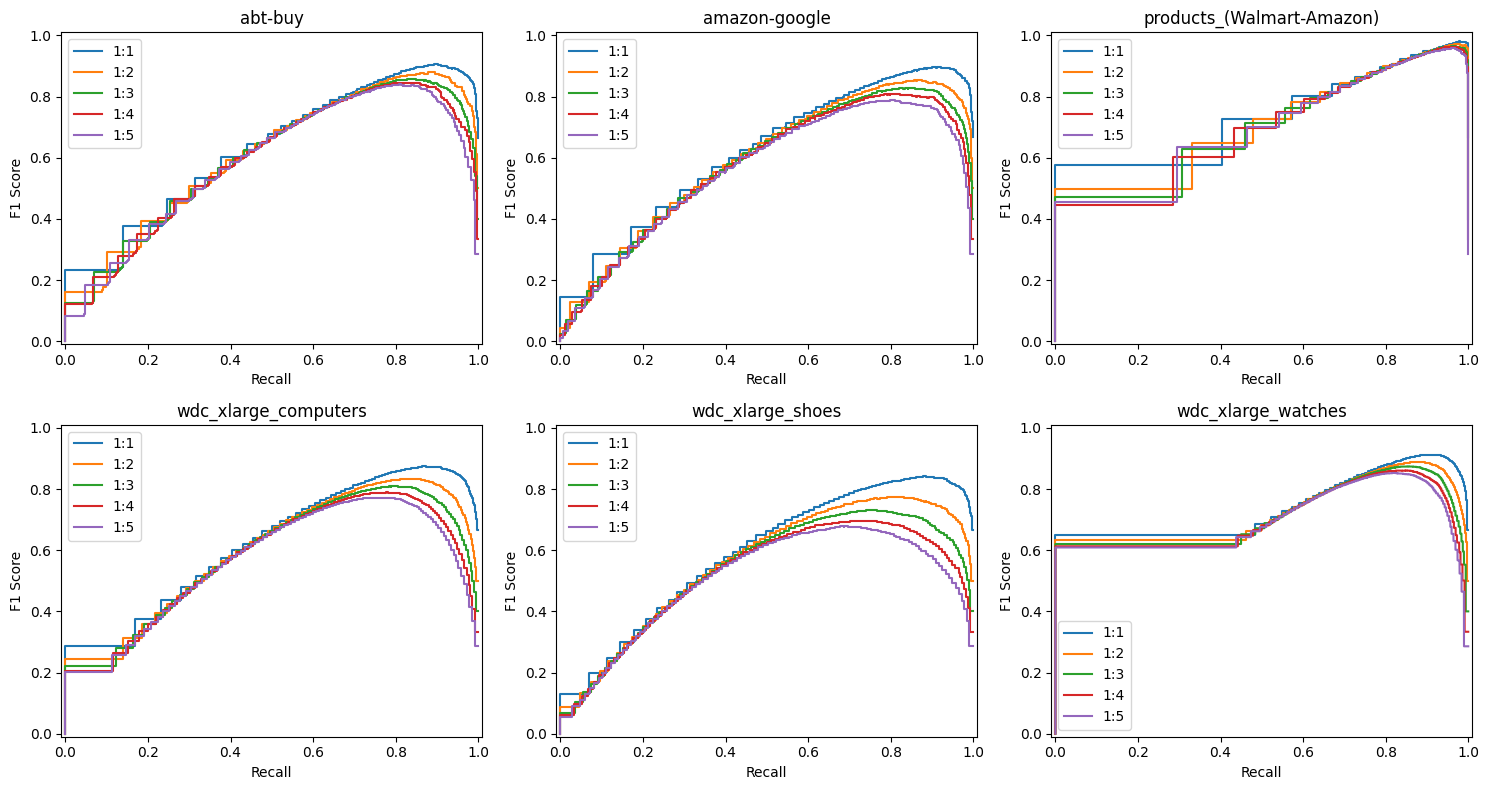

In [11]:
def plot(ax, key, train_N, test_N):
    all_y_prob = cache.load(f'{cache_dir}/{key}_{train_N}')
    subset = all_y_prob.filter(pl.col('label') | (pl.col('N') < test_N))
    y_val = subset.filter(pl.col('set') == 'test')['label'].to_list()
    y_prob = subset.filter(pl.col('set') == 'test')['y_prob'].to_numpy()
    precision, recall, threshold = precision_recall_curve(y_val, y_prob)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_score = 2 * recall * precision / (recall + precision)
    ax.step(recall, f1_score, where='post', label=f'1:{train_N}')
    
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for j, key in enumerate(dataset_names):
    ax = axes[j // 3][j % 3]
    for i in range(1, 6):
        plot(ax, key, i, i)
    ax.legend()
    ax.set_title(key)
    ax.set_xlabel('Recall')
    ax.set_ylabel('F1 Score')
    ax.set_xlim((-0.01, 1.01))
    ax.set_ylim((-0.01, 1.01))
plt.tight_layout()
plt.show()

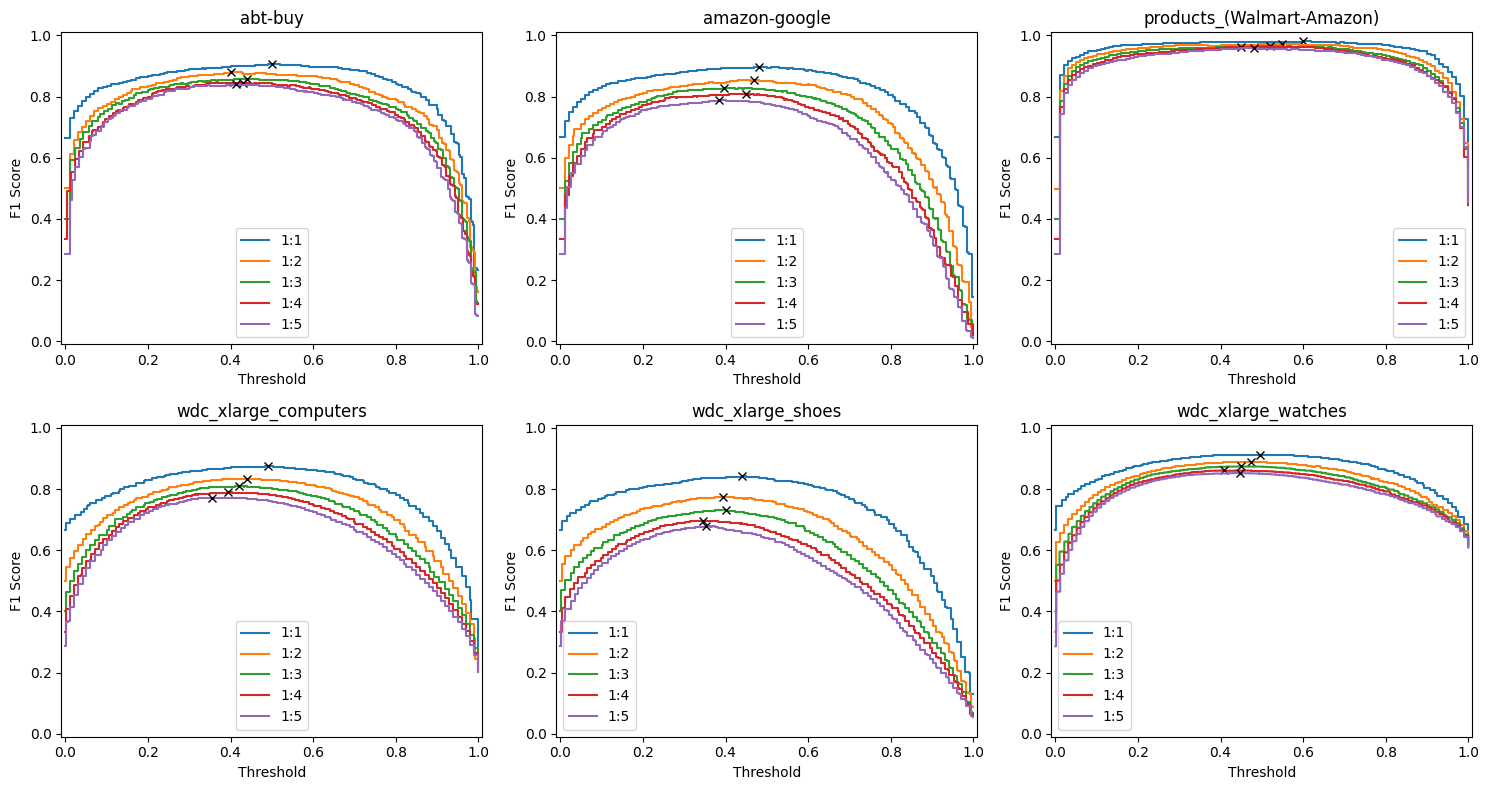

In [12]:
def plot(ax, key, train_N, test_N):
    all_y_prob = cache.load(f'{cache_dir}/{key}_{train_N}')
    subset = all_y_prob.filter(pl.col('label') | (pl.col('N') < test_N))
    y_val = subset.filter(pl.col('set') == 'test')['label'].to_list()
    y_prob = subset.filter(pl.col('set') == 'test')['y_prob'].to_numpy()
    precision, recall, threshold = precision_recall_curve(y_val, y_prob)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_score = 2 * recall * precision / (recall + precision)
    ax.step(threshold[::-1], f1_score[:-1][::-1], where='pre', label=f'1:{train_N}')
    ax.plot(threshold[np.argmax(f1_score)], max(f1_score), marker='x', color='black')
    
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for j, key in enumerate(dataset_names):
    ax = axes[j // 3][j % 3]
    for i in range(1, 6):
        plot(ax, key, i, i)
    ax.legend()
    ax.set_title(key)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 Score')
    ax.set_xlim((-0.01, 1.01))
    ax.set_ylim((-0.01, 1.01))
plt.tight_layout()
plt.show()